# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

%matplotlib inline

np.set_printoptions(suppress=True)

RANDOM_STATE = 732568

## Загрузка данных

In [2]:
def load_dataset(dataset_name):
    return pd.read_csv('/datasets/' + dataset_name)

In [3]:
def general_info(df: pd.core.frame.DataFrame):
    rows_number = 5
    
    separator_symbols_count = 100
    
    print(f'Первые {rows_number} строк датасета')
    display(df.head(rows_number))
    print('='*separator_symbols_count, '\n')
    print('Общая информация о признаках')
    print()
    display(df.info())
    print('='*separator_symbols_count, '\n')
    print('Количество признаков, которые имеют пропущенные значения:', df.isna().any().sum())
    print()
    print('Доля признаков, которые имеют пропущенные значения',
          round(df.isna().any().sum() / df.shape[1], 2))
    print()
    print('='*separator_symbols_count, '\n')
    print('Количество явных дубликатов:', df.duplicated().sum())
    print()
    print('='*separator_symbols_count, '\n')
    print('Описательные статистики признаков')
    display(df.describe().round(2))
    print('='*separator_symbols_count, '\n')
    print('Коэффициенты корреляции признаков')
    display(df.corr().style.background_gradient().set_precision(2))
    print('='*separator_symbols_count, '\n')
    print('Гистограммы и парные диаграммы рассеивания')
    sns.pairplot(
        df,
        kind='scatter'
    );
    

Первые 5 строк датасета


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0



Общая информация о признаках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None


Количество признаков, которые имеют пропущенные значения: 0

Доля признаков, которые имеют пропущенные значения 0.0


Количество явных дубликатов: 153


Описательные статистики признаков


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.0,5000.00,5000.00,5000.00,5000.00
mean,0.5,30.95,39916.36,1.19,0.15
std,0.5,8.44,9900.08,1.09,0.46
min,0.0,18.00,5300.00,0.00,0.00
25%,0.0,24.00,33300.00,0.00,0.00
50%,0.0,30.00,40200.00,1.00,0.00
75%,1.0,37.00,46600.00,2.00,0.00
max,1.0,65.00,79000.00,6.00,5.00



Коэффициенты корреляции признаков


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.00,0.00,0.01,-0.01,0.01
Возраст,0.00,1.00,-0.02,-0.01,0.65
Зарплата,0.01,-0.02,1.00,-0.03,-0.01
Члены семьи,-0.01,-0.01,-0.03,1.00,-0.04
Страховые выплаты,0.01,0.65,-0.01,-0.04,1.00



Гистограммы и парные диаграммы рассеивания


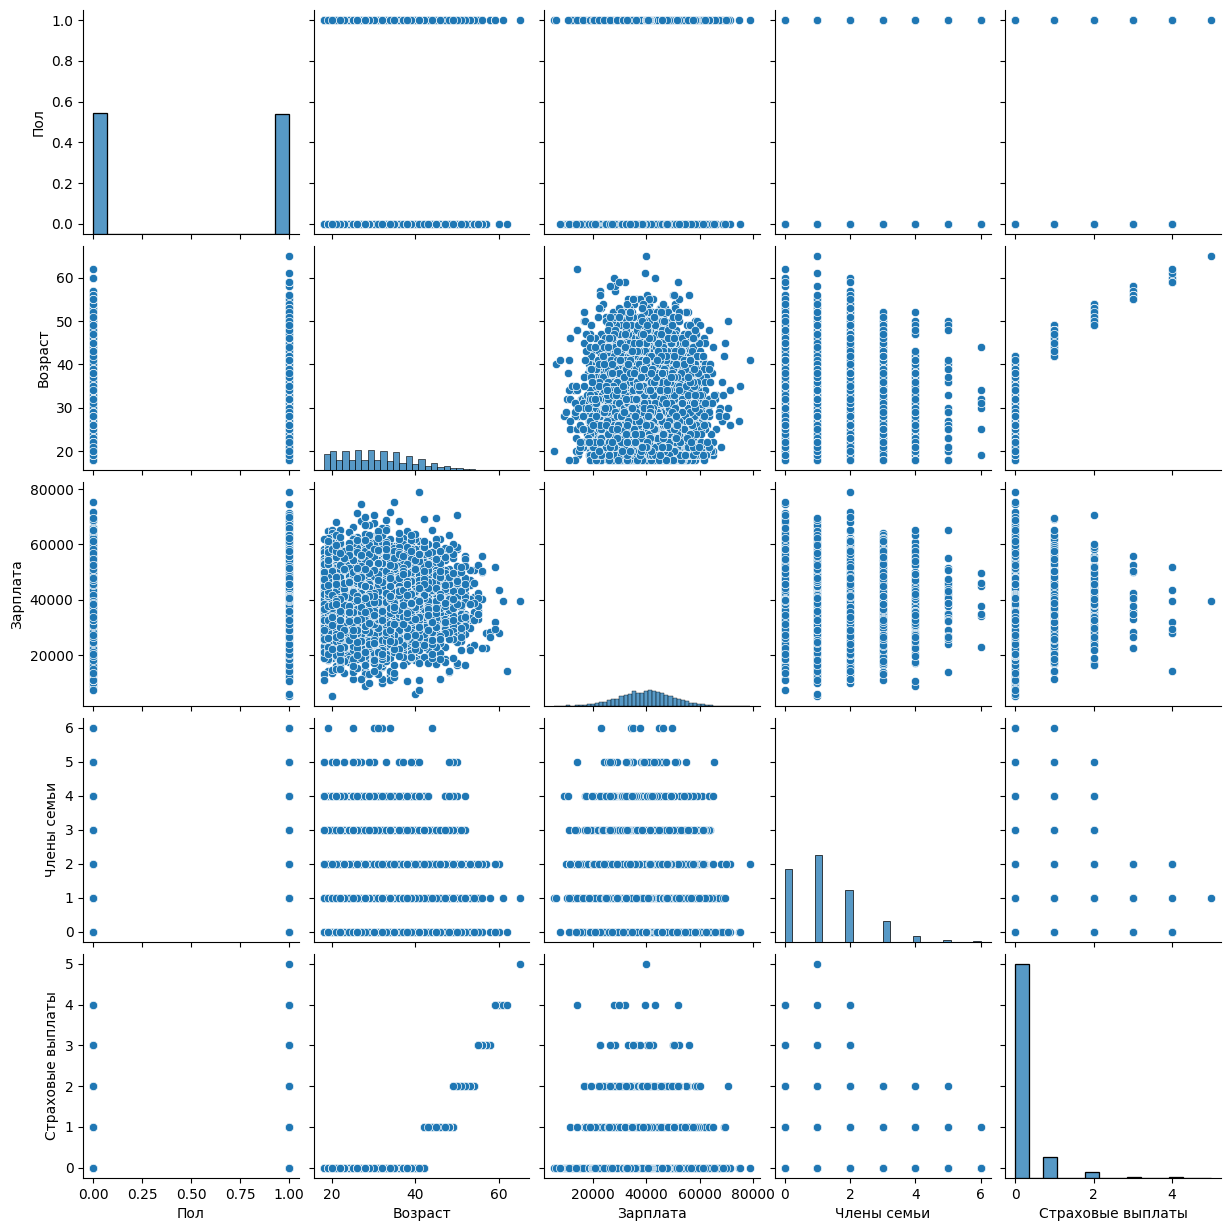

In [4]:
data = load_dataset('insurance.csv')
general_info(data)

Переименуем признаки к формату `snake_case` по общепринятым для Python стандартам

In [5]:
data.columns

Index(['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты'], dtype='object')

In [6]:
rename_columns = {
    'Пол': 'gender',
    'Возраст': 'age',
    'Зарплата': 'salary',
    'Члены семьи': 'family_members',
    'Страховые выплаты': 'insurance_payments'
}
data.rename(columns=rename_columns, inplace=True)

In [7]:
data.columns

Index(['gender', 'age', 'salary', 'family_members', 'insurance_payments'], dtype='object')

Выведем гистограммы признаков  `age`, `salary`, `family_members`, `insurance_payments` отдельно

In [8]:
ages_number = int(data.age.describe()['max'] - data.age.describe()['min'] + 1)
ages_number

48

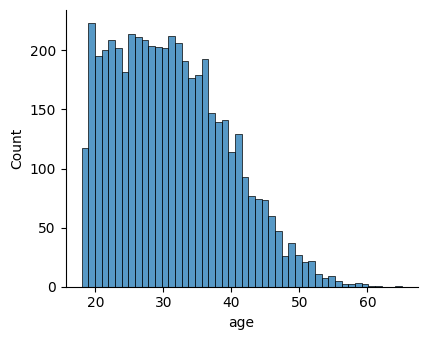

In [9]:
sns.displot(
    data.age,
    bins=ages_number,
    height=3.5,
    aspect=1.25
);

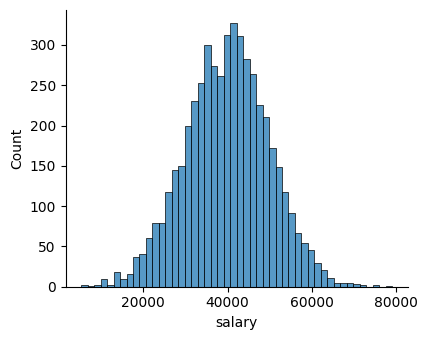

In [10]:
sns.displot(
    data.salary,
    height=3.5,
    aspect=1.25
);

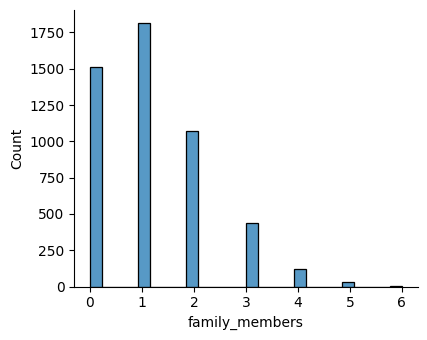

In [11]:
sns.displot(
    data.family_members,
    height=3.5,
    aspect=1.25
);

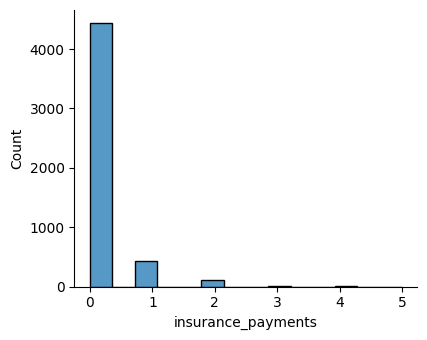

In [12]:
sns.displot(
    data.insurance_payments,
    height=3.5,
    aspect=1.25
);

## Умножение матриц

__Задание:__

Ответьте на вопрос и обоснуйте решение.

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
 - a. Изменится. Приведите примеры матриц.
 - b. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** __Не изменится__

**Обоснование:** 

Чтобы обосновать ответ используем следующие свойства операций с матрицами:

Свойство транспонирования матриц:
$$
(A B)^T = B^T A^T
$$

Свойства обратной и единичной матриц:
$$
(A B)^{-1} = B^{-1} A^{-1}
$$

$$
A A^{-1} = A^{-1} A = E
$$

$$
A E = E A = A
$$

Ассоциативность умножения матриц:

$$
(A B) C = A (B C)
$$

Теперь перейдём к выводу.\
Определим новую матрицу признаков $X_{tfr}$, индекс $tfr$ - transformed:

$$
X_{tfr} = X P
$$

Теперь  подставим $X_{tfr}$ в формулу обучения и получим $w_{tfr}$:

$$
w_{tfr} = ((X P)^T X P)^{-1} (X P)^T y
$$

Упростим формулу:

$$
w_{tfr} = (P^T X^T X P)^{-1} P^T X^T y
$$

$$
w_{tfr} = (P^T (X^T X P))^{-1} P^T X^T y
$$

$$
w_{tfr} = (X^T X P)^{-1} (P^T)^{-1} P^T X^T y
$$

$$
w_{tfr} = (X^T X P)^{-1} ((P^T)^{-1} P^T) X^T y
$$

$$
w_{tfr} = (X^T X P)^{-1} E X^T y
$$

$$
w_{tfr} = ((X^T X) P)^{-1} E X^T y
$$

$$
w_{tfr} = P^{-1} (X^T X)^{-1} X^T y
$$

$$
w_{tfr} = P^{-1} ((X^T X)^{-1} X^T y)
$$

Множитель в правой части справа от $P^{-1}$ это исходный вектор $w$, то есть получаем:

$$
w_{tfr} = P^{-1} w
$$

Далее подставим $X_{tfr}$ и $w_{tfr}$ в формулу предсказания:

$$
a = X P P^{-1} w
$$

$$
a = X (P P^{-1}) w
$$

$$
a = X E w
$$

$$
a = X w
$$

В итоге получаем исходную формулу из чего можно сделать вывод, что качество модели не изменится при умножении признаков на обратимую матрицу

## Алгоритм преобразования

**Алгоритм**

Умножить признаки на обратимую (квадратную) матрицу размером $n*n$, где $n$ это количество признаков в исходном датасете

**Обоснование**

Умножение признаков на квадратную обратимую матрицу позволяет преобразовать данные к виду, из которого восстановить исхоодные данные можно только при наличии обратной матрицы.

## Проверка алгоритма

In [13]:
features = data.drop('insurance_payments', axis=1).values
target = data.insurance_payments.values

In [14]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [15]:
features_train.shape, target_train.shape

((3750, 4), (3750,))

Обучим модель `LinearRegression` на исходных данных и расчитаем $R^2$ метрику на обучающей и тестовой выборках

In [16]:
model = LinearRegression()
model.fit(features_train, target_train)

predicted_train = model.predict(features_train)
print('R2 на обучающей выборке', r2_score(target_train, predicted_train).round(2))

predicted_test = model.predict(features_test)
print('R2 на тестовой выборке', r2_score(target_test, predicted_test).round(2))

R2 на обучающей выборке 0.42
R2 на тестовой выборке 0.44


In [17]:
w = model.coef_
w.round(4)

array([ 0.0072,  0.0354,  0.    , -0.0154])

Создадим случайную обратимую квадратную матрицу с размером равным количеству признаков

In [18]:
matrix_size = features_train.shape[1]
matrix_size

4

In [21]:
def get_transform_matrix_pair(matrix_size):
    random_state = np.random.RandomState(RANDOM_STATE)
    transform_matrix = random_state.normal(size=(matrix_size, matrix_size))
    try: 
        inverse_matrix = np.linalg.inv(transform_matrix)
        return transform_matrix, inverse_matrix
    except:
        get_transform_matrix_pair(matrix_size)  

In [22]:
transform_matrix, inverse_matrix = get_transform_matrix_pair(matrix_size)

In [23]:
transform_matrix.shape, transform_matrix

((4, 4),
 array([[ 0.60998268, -0.81295414,  0.37402288,  0.73586036],
        [ 0.53621097,  2.16037708,  0.81551961,  2.07535988],
        [-1.34089311,  1.16205872, -1.56406117,  0.30893069],
        [-1.84947595,  1.46764226, -0.11509867, -1.84391106]]))

In [24]:
inverse_matrix.shape, inverse_matrix

((4, 4),
 array([[-2.28733909,  0.03335761, -0.45951462, -0.95226463],
        [-1.16926238,  0.24318264, -0.13692919, -0.21585855],
        [ 1.34498637,  0.18146613, -0.27425656,  0.69504621],
        [ 1.27962442,  0.14877318,  0.36903338,  0.19761719]]))

Трансформируем признаки в обучающей и тестовой выборках

In [25]:
features_train_transformed = features_train @ transform_matrix
features_train_transformed.shape

(3750, 4)

In [26]:
print('Первые пять строк трансформированной матрицы признаков\n')
print(features_train_transformed[:5].round(4))

Первые пять строк трансформированной матрицы признаков

[[-49738.2597  43157.0537 -58010.474   11500.992 ]
 [-70518.5903  61192.0353 -82245.382   16308.3274]
 [-64755.9127  56200.2785 -75519.3336  14978.313 ]
 [-39803.077   34599.5591 -46419.9959   9258.256 ]
 [-51615.1409  44791.0718 -60197.4541  11938.613 ]]


In [27]:
print('Первые пять строк исходной матрицы признаков\n')
print(features_train[:5])

Первые пять строк исходной матрицы признаков

[[    0.    20. 37100.     1.]
 [    0.    30. 52600.     2.]
 [    0.    31. 48300.     4.]
 [    0.    40. 29700.     0.]
 [    1.    23. 38500.     2.]]


In [28]:
features_test_transformed = features_test @ transform_matrix
features_test_transformed.shape

(1250, 4)

Теперь обучим модель `LinearRegression` на трансформированных данных и также расчитаем $R^2$ метрику

In [29]:
model_tfr = LinearRegression()
model_tfr.fit(features_train_transformed, target_train)

predicted_train_tfr = model_tfr.predict(features_train_transformed)
print('R2 на обучающей выборке', r2_score(target_train, predicted_train_tfr).round(2))

predicted_test_tfr = model_tfr.predict(features_test_transformed)
print('R2 на тестовой выборке', r2_score(target_test, predicted_test_tfr).round(2))

R2 на обучающей выборке 0.42
R2 на тестовой выборке 0.44


Видим, что $R^2$ метрика не изменилась, после обучения на трансформированных данных

In [30]:
w_tfr = model_tfr.coef_
w_tfr

array([-0.000614  ,  0.00354038,  0.00541298,  0.01142307])

Проверим, что коэффициенты $w_{tfr}$ вычисляются по формуле:
$$
w_{tfr} = P^{-1} w
$$

In [31]:
inverse_matrix @ w

array([-0.000614  ,  0.00354038,  0.00541298,  0.01142307])

In [32]:
w_tfr

array([-0.000614  ,  0.00354038,  0.00541298,  0.01142307])

Теперь пробуем восстановить исходные данные из трансформированных по формуле:
$$
X_{tfr} P^{-1} = X
$$

In [33]:
features_train_transformed_inverse = features_train_transformed @ inverse_matrix

In [34]:
print('Первые пять строк восстановленой матрицы признаков\n')
print(features_train_transformed_inverse[:5])

Первые пять строк восстановленой матрицы признаков

[[   -0.    20. 37100.     1.]
 [   -0.    30. 52600.     2.]
 [   -0.    31. 48300.     4.]
 [   -0.    40. 29700.    -0.]
 [    1.    23. 38500.     2.]]


In [35]:
print('Первые пять строк исходной матрицы признаков\n')
print(features_train[:5].round(5))

Первые пять строк исходной матрицы признаков

[[    0.    20. 37100.     1.]
 [    0.    30. 52600.     2.]
 [    0.    31. 48300.     4.]
 [    0.    40. 29700.     0.]
 [    1.    23. 38500.     2.]]


__Общий вывод по проекту:__

В ходе выполнения проекта получены следущие результаты:
 - загружены и изучены данные клиентов страховой компании «Хоть потоп»:
    - датасет содержит 5000 строк-объектов с 5-ю признаками, в том числе целевой признак;
 - изучен вопрос об изменении качества линейной регрессии при умножении признаков на обратимую матрицу:
    - установлено, что качество регрессии не изменится: в проекте в разделе 2 представлен аналитический вывод;
 - на основе изученного вопроса предложен алгоритм преобразования данных путём умножения признаков на обратимую (квадратную) матрицу размером $n*n$, где $n$ это количество признаков в исходном датасете;
 - в разделе 4. проведена проверка предложенного алгоритма:
    - на предоставленных данных обучена модель линейной регресии и рассчитана $R^2$ метрика до и после трансформации данных и показано, что $R^2$ метрика не меняется.

